# Common imports

In [33]:
%matplotlib inline
import os
import sys
import glob
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
import time

# Provided functions
### Image loading and saving

In [34]:
def LoadFaceImages(pathname, subject_name, num_images):
    """
    Load the set of face images.  
    The routine returns
        ambimage: image illuminated under the ambient lighting
        imarray: a 3-D array of images, h x w x Nimages
        lightdirs: Nimages x 3 array of light source directions
    """

    def load_image(fname):
        return np.asarray(Image.open(fname))

    def fname_to_ang(fname):
        yale_name = os.path.basename(fname)
        return int(yale_name[12:16]), int(yale_name[17:20])

    def sph2cart(az, el, r):
        rcos_theta = r * np.cos(el)
        x = rcos_theta * np.cos(az)
        y = rcos_theta * np.sin(az)
        z = r * np.sin(el)
        return x, y, z

    ambimage = load_image(
        os.path.join(pathname, subject_name + '_P00_Ambient.pgm'))
    im_list = glob.glob(os.path.join(pathname, subject_name + '_P00A*.pgm'))
    if num_images <= len(im_list):
        im_sub_list = np.random.choice(im_list, num_images, replace=False)
    else:
        print(
            'Total available images is less than specified.\nProceeding with %d images.\n'
            % len(im_list))
        im_sub_list = im_list
    im_sub_list.sort()
    imarray = np.stack([load_image(fname) for fname in im_sub_list], axis=-1)
    Ang = np.array([fname_to_ang(fname) for fname in im_sub_list])

    x, y, z = sph2cart(Ang[:, 0] / 180.0 * np.pi, Ang[:, 1] / 180.0 * np.pi, 1)
    lightdirs = np.stack([y, z, x], axis=-1)
    return ambimage, imarray, lightdirs

In [35]:
def save_outputs(subject_name, albedo_image, surface_normals):
    im = Image.fromarray((albedo_image*255).astype(np.uint8))
    im.save("%s_albedo.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,0]*128+128).astype(np.uint8))
    im.save("%s_normals_x.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,1]*128+128).astype(np.uint8))
    im.save("%s_normals_y.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,2]*128+128).astype(np.uint8))
    im.save("%s_normals_z.jpg" % subject_name)

### Plot the height map

In [50]:
def set_aspect_equal_3d(ax):
    """https://stackoverflow.com/questions/13685386"""
    """Fix equal aspect bug for 3D plots."""
    xlim = ax.get_xlim3d()
    ylim = ax.get_ylim3d()
    zlim = ax.get_zlim3d()
    from numpy import mean
    xmean = mean(xlim)
    ymean = mean(ylim)
    zmean = mean(zlim)
    plot_radius = max([
        abs(lim - mean_)
        for lims, mean_ in ((xlim, xmean), (ylim, ymean), (zlim, zmean))
        for lim in lims
    ])
    ax.set_xlim3d([xmean - plot_radius, xmean + plot_radius])
    ax.set_ylim3d([ymean - plot_radius, ymean + plot_radius])
    ax.set_zlim3d([zmean - plot_radius, zmean + plot_radius])


def display_output(albedo_image, height_map):
    fig = plt.figure()
    plt.imshow(albedo_image, cmap='gray')
    plt.axis('off')
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca(projection='3d')
    ax.view_init(20, 70)
    X = np.arange(albedo_image.shape[0])
    Y = np.arange(albedo_image.shape[1])
    X, Y = np.meshgrid(Y, X)
    H = np.flipud(np.fliplr(height_map))
    A = np.flipud(np.fliplr(albedo_image))
    A = np.stack([A, A, A], axis=-1)
    ax.xaxis.set_ticks([])
    ax.xaxis.set_label_text('Z')
    ax.yaxis.set_ticks([])
    ax.yaxis.set_label_text('X')
    ax.zaxis.set_ticks([])
    ax.yaxis.set_label_text('Y')
    surf = ax.plot_surface(
        H, X, Y, cmap='gray', facecolors=A, linewidth=0, antialiased=False)
    set_aspect_equal_3d(ax)

### Plot the surface norms. 

In [37]:
def plot_surface_normals(surface_normals):
    """
    surface_normals: h x w x 3 matrix.
    """
    fig = plt.figure()
    ax = plt.subplot(1, 3, 1)
    ax.axis('off')
    ax.set_title('X')
    im = ax.imshow(surface_normals[:,:,0], cmap='jet')
    ax = plt.subplot(1, 3, 2)
    ax.axis('off')
    ax.set_title('Y')
    im = ax.imshow(surface_normals[:,:,1], cmap='jet')
    ax = plt.subplot(1, 3, 3)
    ax.axis('off')
    ax.set_title('Z')
    im = ax.imshow(surface_normals[:,:,2], cmap='jet')
    cbar_ax = fig.add_axes([0.92, 0.25, 0.04, 0.5])
    plt.colorbar(im, cax=cbar_ax)

# Your implementation

In [38]:
def preprocess(ambimage, imarray):
    """
    preprocess the data: 
        1. subtract ambient_image from each image in imarray.
        2. make sure no pixel is less than zero.
        3. rescale values in imarray to be between 0 and 1.
    Inputs:
        ambimage: h x w
        imarray: h x w x Nimages
    Outputs:
        processed_imarray: h x w x Nimages
    """
    (H, W) = ambimage.shape
    sub_imarray = imarray - ambimage.reshape(H, W, 1)
    clipped_array = np.zeros(sub_imarray.shape)
    clipped_imarray = np.zeros(sub_imarray.shape)
    np.clip(sub_imarray, 0, None, out=clipped_imarray)
    processed_imarray = clipped_imarray / 255.0
    return processed_imarray

In [39]:
def photometric_stereo(imarray, light_dirs):
    """
    Inputs:
        imarray:  h x w x Nimages
        light_dirs: Nimages x 3
    Outputs:
        albedo_image: h x w
        surface_norms: h x w x 3
    """
    (H, W, N) = imarray.shape
    imarray = imarray.transpose(2, 0, 1).reshape(N, H*W)     # (N, H*W)
    print(imarray.shape)
    print(light_dirs.shape)       # (N, 3)
    g = np.linalg.lstsq(light_dirs, imarray, rcond=None)[0]   # (3, H*W)
    print(g.shape)
    albedo_image = np.linalg.norm(g, axis=0)   # (1, H*W)
    print(albedo_image.shape)
    surface_normals = g / albedo_image         # (3, H*W)
    print(surface_normals.shape)
    #assert g.shape == (3, H, W)   
    albedo_out = albedo_image.reshape(H, W)
    surface_out = surface_normals.reshape(3, H, W).transpose(1, 2, 0)
    print(albedo_out.shape)
    print(surface_out.shape)
    
    return albedo_out, surface_out

In [57]:
def get_surface(surface_normals, integration_method):
    """
    Inputs:
        surface_normals: h x w x 3
        integration_method: string in ['average', 'column', 'row', 'random']
    Outputs:
        height_map: h x w
    """
    (H, W) = surface_normals.shape[:2]
    fx = surface_normals[:, :, 0] / surface_normals[:, :, 2]
    fy = surface_normals[:, :, 1] / surface_normals[:, :, 2]
    height_map = np.zeros((H, W))
    #print('fx:', fx)
    #print('fy:', fy)
    print(integration_method)
    
    if integration_method == 'average':
        for y in range(H):
            for x in range(W):
                height_map[y, x] = np.sum(fx[y, :x]) + np.sum(fy[:y, 0]) \
                                   + np.sum(fx[0, :x]) + np.sum(fy[:y, x])
                height_map[y, x] = int(height_map[y, x] / 2)
        
    elif integration_method == 'column':
        for y in range(H):
            for x in range(W):
                height_map[y, x] = np.sum(fx[y, :x]) + np.sum(fy[:y, 0])
            
    elif integration_method == 'row':
        for y in range(H):
            for x in range(W):
                height_map[y, x] = np.sum(fx[0, :x]) + np.sum(fy[:y, x])
        
    elif integration_method == 'random':
        num_path = 10        
        for p in range(num_path):
            #print(p)
            for y in range(H):
                for x in range(W):
                    h, w = 0, 0
                    fxy = 0
                    while (h <= y and w <= x):
                        if (h == y and w == x):  break
                        elif h == y:
                            w += 1
                            fxy += fx[h, w]
                        elif w == x:
                            h += 1
                            fxy += fy[h, w]
                        else:
                            if np.random.randint(2):
                                w += 1
                                fxy += fx[h, w]
                            else:
                                h += 1
                                fxy += fy[h, w]
                    height_map[y, x] += fxy
        height_map /= num_path
        
    #print(height_map)
    return height_map

# Main function

In [41]:
root_path = 'croppedyale/'
subject_name = 'yaleB05'
integration_method = 'average'
save_flag = True

full_path = '%s%s' % (root_path, subject_name)
ambient_image, imarray, light_dirs = LoadFaceImages(full_path, subject_name,
                                                    64)

processed_imarray = preprocess(ambient_image, imarray)

albedo_image, surface_normals = photometric_stereo(processed_imarray,
                                                   light_dirs)
#height_map = get_surface(surface_normals, 'row')
if save_flag:
    save_outputs(subject_name, albedo_image, surface_normals)
print('done')

Total available images is less than specified.
Proceeding with 38 images.

(38, 32256)
(38, 3)
(3, 32256)
(32256,)
(3, 32256)
(192, 168)
(192, 168, 3)
done


(192, 168)
(192, 168, 3)


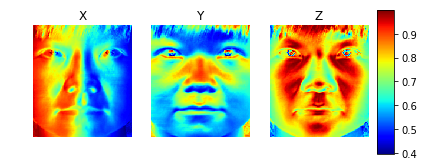

In [42]:
print(albedo_image.shape)
print(surface_normals.shape)
plot_surface_normals(surface_normals)

In [52]:
start_time = time.time()
height_map = get_surface(surface_normals, 'row')
print('time:', time.time() - start_time)
#display_output(albedo_image, height_map)
#print(height_map)

row
time: 0.3406393527984619


In [53]:
start_time = time.time()
height_map = get_surface(surface_normals, 'column')
print('time:', time.time() - start_time)
#display_output(albedo_image, height_map)

column
time: 0.33734893798828125


In [54]:
start_time = time.time()
height_map = get_surface(surface_normals, 'average')
print('time:', time.time() - start_time)
#display_output(albedo_image, height_map)

average
time: 0.6634187698364258


In [58]:
start_time = time.time()
height_map = get_surface(surface_normals, 'random')
print('time:', time.time() - start_time)
#display_output(albedo_image, height_map)

random
time: 113.09931802749634


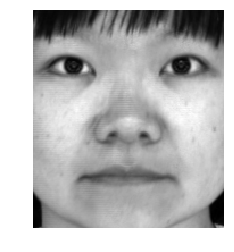

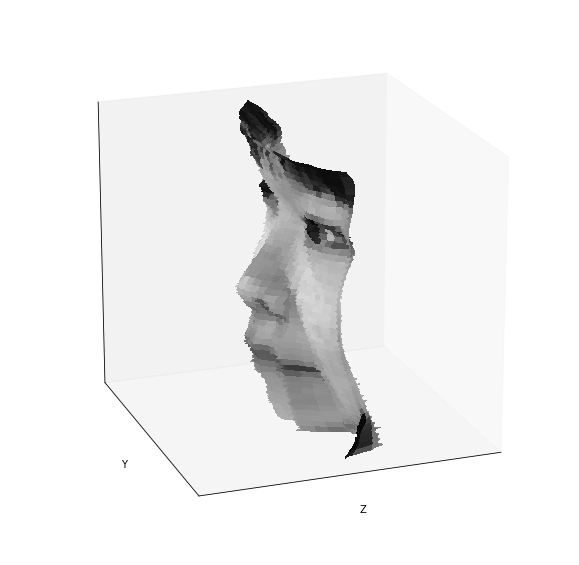

In [51]:
display_output(albedo_image, height_map)